In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from difflib import SequenceMatcher
from transformers import AutoTokenizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [ ]:
df = pd.read_json("hf://datasets/UCSC-VLAA/MedReason/ours_quality_33000.jsonl", lines=True)

In [ ]:
def view_sample_answers(dataset, num_rows=5):
    for i in range(num_rows):
        print(dataset.iloc[i]['answer'])
        print('*' * 50)

def view_sample_options(dataset, num_rows=5):
    for i in range(num_rows):
        print(dataset.iloc[i]['options'])
        print('*' * 50)

def view_sample_questions(dataset, num_rows=5):
    for i in range(num_rows):
        print(dataset.iloc[i]['question'])
        print('*' * 50)

# Preprocessing - Filtered subsets

## MedMCQA

In [ ]:
medmcqa_qs = df[df['dataset_name'] == 'medmcqa'].copy()
medmcqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options
0,medmcqa,7131,Urogenital Diaphragm is made up of the followi...,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Answer Choices:\nA. Deep transverse Perineus\n...
1,medmcqa,7133,Child with Type I Diabetes. What is the advise...,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Answer Choices:\nA. After 5 years\nB. After 2 ...
2,medmcqa,7134,Most sensitive test for H pylori is-,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Answer Choices:\nA. Fecal antigen test\nB. Bio...
3,medmcqa,7137,Ligation of the common hepatic aery will compr...,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Answer Choices:\nA. Right and Left gastric aer...
4,medmcqa,7138,Typhoid investigation of choice in 1st week,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Answer Choices:\nA. Blood culture\nB. Widal te...
...,...,...,...,...,...,...
29157,medmcqa,7125,A 60-year-old nursing home resident presents w...,Contact precautions. Explanation: There are fo...,### Finding Reasoning Paths:\n1. **Clinical Pr...,Answer Choices:\nA. Standard precautions\nB. C...
29158,medmcqa,7126,Transcripton is inhibited by:,Actinomycin D. Explanation: A i.e. Actinomycin,### Finding Reasoning Paths:\n1. mRNA transcri...,Answer Choices:\nA. Actinomycin D\nB. Amanitin...
29159,medmcqa,7128,Triage is –,Categorisation of the patients and treating th...,### Finding Reasoning Paths:\n1. **Severity of...,Answer Choices:\nA. Treating the most serious ...
29160,medmcqa,7129,All of the following are true in respect of he...,Autosomal recessive disorder. Explanation: Her...,### Finding Reasoning Paths:\n1. **Complement ...,Answer Choices:\nA. Deficiency of C1 inhibitor...


In [ ]:
def count_answer_choices(text):
    if pd.isnull(text):
        return 0
    lines = text.strip().split('\n')
    choice_lines = lines[1:]
    count = sum(bool(re.match(r'^[A-Z]\.', line.strip())) for line in choice_lines)
    return count

medmcqa_qs['num_choices'] = medmcqa_qs['options'].apply(count_answer_choices)

In [ ]:
medmcqa_qs['num_choices'].value_counts()

,count
num_choices,
4,6197


In [ ]:
def clean_text(text):
    """Lowercase, remove newlines/tabs/extra spaces, strip, remove trailing period."""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # replace all whitespace (including \n, \t) with single space
    text = text.strip()
    text = text.rstrip('.')
    return text

def extract_mcq_label_fuzzy(answer_text, options_text, threshold=0.9):
    """
    Extracts MCQ letter (A-D) corresponding to the correct answer using fuzzy matching.
    Only uses cleaned text for matching; original text remains unchanged.
    """
    # Clean main answer (before Explanation:)
    answer_main = clean_text(answer_text.split("Explanation:")[0])

    # Extract options
    matches = re.findall(r'([A-D])\.\s*(.*)', options_text)

    best_letter = None
    best_ratio = 0

    for letter, text in matches:
        option_text = clean_text(text)
        ratio = SequenceMatcher(None, answer_main, option_text).ratio()
        if ratio > best_ratio and ratio >= threshold:
            best_ratio = ratio
            best_letter = letter

    return best_letter

In [ ]:
medmcqa_qs['answer_label'] = medmcqa_qs.apply(lambda row: extract_mcq_label_fuzzy(row['answer'], row['options']), axis=1)

medmcqa_qs['answer_label'].value_counts(dropna=False)

,count
answer_label,
A,1921
B,1554
C,1528
D,1194


In [ ]:
medmcqa_qs["question_type"] = "MCQ"
medmcqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,num_choices,answer_label,question_type
0,medmcqa,7131,Urogenital Diaphragm is made up of the followi...,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Answer Choices:\nA. Deep transverse Perineus\n...,4,C,MCQ
1,medmcqa,7133,Child with Type I Diabetes. What is the advise...,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Answer Choices:\nA. After 5 years\nB. After 2 ...,4,A,MCQ
2,medmcqa,7134,Most sensitive test for H pylori is-,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Answer Choices:\nA. Fecal antigen test\nB. Bio...,4,B,MCQ
3,medmcqa,7137,Ligation of the common hepatic aery will compr...,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Answer Choices:\nA. Right and Left gastric aer...,4,D,MCQ
4,medmcqa,7138,Typhoid investigation of choice in 1st week,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Answer Choices:\nA. Blood culture\nB. Widal te...,4,A,MCQ
...,...,...,...,...,...,...,...,...,...
29157,medmcqa,7125,A 60-year-old nursing home resident presents w...,Contact precautions. Explanation: There are fo...,### Finding Reasoning Paths:\n1. **Clinical Pr...,Answer Choices:\nA. Standard precautions\nB. C...,4,B,MCQ
29158,medmcqa,7126,Transcripton is inhibited by:,Actinomycin D. Explanation: A i.e. Actinomycin,### Finding Reasoning Paths:\n1. mRNA transcri...,Answer Choices:\nA. Actinomycin D\nB. Amanitin...,4,A,MCQ
29159,medmcqa,7128,Triage is –,Categorisation of the patients and treating th...,### Finding Reasoning Paths:\n1. **Severity of...,Answer Choices:\nA. Treating the most serious ...,4,B,MCQ
29160,medmcqa,7129,All of the following are true in respect of he...,Autosomal recessive disorder. Explanation: Her...,### Finding Reasoning Paths:\n1. **Complement ...,Answer Choices:\nA. Deficiency of C1 inhibitor...,4,D,MCQ


## PubMedQA

In [ ]:
pubmedqa_qs = df[df['dataset_name'] == "pubmedqa"].copy()
pubmedqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options
13055,pubmedqa,0,Do mitochondria play a role in remodelling lac...,The final decision is: yes. Results depicted m...,### Finding Reasoning Paths:\n1. Mitochondria ...,Answer Choices:\nA. Yes\nB. No
13056,pubmedqa,1,Landolt C and snellen e acuity: differences in...,The final decision is: no. Using the charts de...,### Finding Reasoning Paths:\n1. Strabismus ->...,Answer Choices:\nA. Yes\nB. No
13057,pubmedqa,4,Can tailored interventions increase mammograph...,The final decision is: yes. The effects of the...,### Finding Reasoning Paths:\n1. **Effectivene...,Answer Choices:\nA. Yes\nB. No
13058,pubmedqa,9,A short stay or 23-hour ward in a general and ...,The final decision is: yes. This data demonstr...,### Finding Reasoning Paths:\n1. **Bed Efficie...,Answer Choices:\nA. Yes\nB. No
13059,pubmedqa,11,Therapeutic anticoagulation in the trauma pati...,The final decision is: no. Trauma patients hav...,### Finding Reasoning Paths:\n1. **Response to...,Answer Choices:\nA. Yes\nB. No
...,...,...,...,...,...,...
13653,pubmedqa,993,Are many colorectal cancers due to missed aden...,The final decision is: no. In normal daily pra...,### Finding Reasoning Paths:\n1. Colorectal ca...,Answer Choices:\nA. Yes\nB. No
13654,pubmedqa,994,Does desflurane alter left ventricular functio...,The final decision is: no. This study demonstr...,### Finding Reasoning Paths:\n1. Desflurane's ...,Answer Choices:\nA. Yes\nB. No
13655,pubmedqa,995,Does gestational age misclassification explain...,The final decision is: no. Gestational age mis...,### Finding Reasoning Paths:\n1. Investigate w...,Answer Choices:\nA. Yes\nB. No
13656,pubmedqa,997,Is peak concentration needed in therapeutic dr...,The final decision is: no. These results sugge...,### Finding Reasoning Paths:\n1. Vancomycin ->...,Answer Choices:\nA. Yes\nB. No


In [ ]:
def extract_decision(text):
    # Regex to find "yes" or "no" after "The final decision is:"
    match = re.search(r"The final decision is:\s*(yes|no|maybe)", text, flags=re.IGNORECASE)
    if match:
        return match.group(1).lower()   # return 'yes' or 'no'
    return None

# Apply to your dataframe
pubmedqa_qs['answer_label'] = pubmedqa_qs['answer'].apply(extract_decision)

# Count distribution
print(pubmedqa_qs['answer_label'].value_counts())

answer_label
yes      421
no       181
maybe      1
Name: count, dtype: int64


In [ ]:
# Remove row with answer_label 'maybe'
pubmedqa_qs = pubmedqa_qs[pubmedqa_qs['answer_label'] != 'maybe']
pubmedqa_qs[['question', 'answer', 'answer_label']]

,question,answer,answer_label
13055,Do mitochondria play a role in remodelling lac...,The final decision is: yes. Results depicted m...,yes
13056,Landolt C and snellen e acuity: differences in...,The final decision is: no. Using the charts de...,no
13057,Can tailored interventions increase mammograph...,The final decision is: yes. The effects of the...,yes
13058,A short stay or 23-hour ward in a general and ...,The final decision is: yes. This data demonstr...,yes
13059,Therapeutic anticoagulation in the trauma pati...,The final decision is: no. Trauma patients hav...,no
...,...,...,...
13653,Are many colorectal cancers due to missed aden...,The final decision is: no. In normal daily pra...,no
13654,Does desflurane alter left ventricular functio...,The final decision is: no. This study demonstr...,no
13655,Does gestational age misclassification explain...,The final decision is: no. Gestational age mis...,no
13656,Is peak concentration needed in therapeutic dr...,The final decision is: no. These results sugge...,no


In [ ]:
pubmedqa_qs["question_type"] = "Y/N"
pubmedqa_qs

/tmp/ipython-input-2260965923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubmedqa_qs["question_type"] = "Y/N"


,dataset_name,id_in_dataset,question,answer,reasoning,options,answer_label,question_type
13055,pubmedqa,0,Do mitochondria play a role in remodelling lac...,The final decision is: yes. Results depicted m...,### Finding Reasoning Paths:\n1. Mitochondria ...,Answer Choices:\nA. Yes\nB. No,yes,Y/N
13056,pubmedqa,1,Landolt C and snellen e acuity: differences in...,The final decision is: no. Using the charts de...,### Finding Reasoning Paths:\n1. Strabismus ->...,Answer Choices:\nA. Yes\nB. No,no,Y/N
13057,pubmedqa,4,Can tailored interventions increase mammograph...,The final decision is: yes. The effects of the...,### Finding Reasoning Paths:\n1. **Effectivene...,Answer Choices:\nA. Yes\nB. No,yes,Y/N
13058,pubmedqa,9,A short stay or 23-hour ward in a general and ...,The final decision is: yes. This data demonstr...,### Finding Reasoning Paths:\n1. **Bed Efficie...,Answer Choices:\nA. Yes\nB. No,yes,Y/N
13059,pubmedqa,11,Therapeutic anticoagulation in the trauma pati...,The final decision is: no. Trauma patients hav...,### Finding Reasoning Paths:\n1. **Response to...,Answer Choices:\nA. Yes\nB. No,no,Y/N
...,...,...,...,...,...,...,...,...
13653,pubmedqa,993,Are many colorectal cancers due to missed aden...,The final decision is: no. In normal daily pra...,### Finding Reasoning Paths:\n1. Colorectal ca...,Answer Choices:\nA. Yes\nB. No,no,Y/N
13654,pubmedqa,994,Does desflurane alter left ventricular functio...,The final decision is: no. This study demonstr...,### Finding Reasoning Paths:\n1. Desflurane's ...,Answer Choices:\nA. Yes\nB. No,no,Y/N
13655,pubmedqa,995,Does gestational age misclassification explain...,The final decision is: no. Gestational age mis...,### Finding Reasoning Paths:\n1. Investigate w...,Answer Choices:\nA. Yes\nB. No,no,Y/N
13656,pubmedqa,997,Is peak concentration needed in therapeutic dr...,The final decision is: no. These results sugge...,### Finding Reasoning Paths:\n1. Vancomycin ->...,Answer Choices:\nA. Yes\nB. No,no,Y/N


## medqa

In [ ]:
medqa_qs = df[df['dataset_name'] == "medqa"].copy()
medqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options
2011,medqa,7595,A 62-year-old man presents with multiple episo...,Small cell carcinoma of the lung,**Finding reasoning paths:**\n\n1. Hemoptysis ...,Answer Choices:\nA. Tuberculoma\nB. Small cell...
2012,medqa,7596,An 84-year-old man is brought to the physician...,Denudation of tubular basement membrane,**Finding reasoning paths:**\n\n1. Decreased u...,Answer Choices:\nA. Leukocytic infiltration of...
2013,medqa,7598,"A 44-year-old man, with a history of intraveno...",Trimethoprim-sulfamethoxazole,Finding reasoning paths:\n1. Non-productive co...,"Answer Choices:\nA. Isoniazid, rifabutin, pyra..."
2014,medqa,7599,A 33-year-old woman comes to the physician bec...,"Optic neuritis\n""",**Finding reasoning paths:**\n\n1. Visual impa...,Answer Choices:\nA. Retinal detachment\nB. Nar...
2015,medqa,7600,A 23-year-old man is brought to the emergency ...,Schizophreniform disorder,Finding reasoning paths:\n1. Behavioral abnorm...,Answer Choices:\nA. Schizoaffective disorder\n...
...,...,...,...,...,...,...
32677,medqa,995,A 51-year-old man is bitten by a cottonmouth v...,Glucocorticoid taper with antihistamines,### Finding Reasoning Paths:\n1. **Pruritis an...,Answer Choices:\nA. Glucocorticoid taper with ...
32678,medqa,996,A 47-year-old man presents to the clinic for a...,Bed bug bite,### Finding Reasoning Paths:\n1. **Pruritus an...,Answer Choices:\nA. Cutaneous larva migrans\nB...
32679,medqa,997,A 24-year-old woman presents to her primary ca...,Motile and helical-shaped bacteria,### Finding Reasoning Paths:\n1. The patient h...,Answer Choices:\nA. Gram-negative coccobacillu...
32680,medqa,998,"A 70-year-old man presents with fever, headach...",Ampicillin,"### Finding Reasoning Paths:\n1. Fever, headac...",Answer Choices:\nA. Ampicillin\nB. Ceftriaxone...


In [ ]:
medqa_qs['num_choices'] = medqa_qs['options'].apply(count_answer_choices)

print(medqa_qs['num_choices'].value_counts())


num_choices
4    8016
Name: count, dtype: int64


In [ ]:
def extract_mcq_label_fuzzy(answer_text, options_text, threshold=0.9):
    """
    Extracts MCQ letter (A-D) corresponding to the correct answer using fuzzy matching.
    Only uses cleaned text for matching; original text remains unchanged.
    """
    answer_main = clean_text(answer_text)

    # Extract options
    matches = re.findall(r'([A-D])\.\s*(.*)', options_text)

    best_letter = None
    best_ratio = 0

    for letter, text in matches:
        option_text = clean_text(text)
        ratio = SequenceMatcher(None, answer_main, option_text).ratio()
        if ratio > best_ratio and ratio >= threshold:
            best_ratio = ratio
            best_letter = letter

    return best_letter

In [ ]:
medqa_qs['answer_label'] = medqa_qs.apply(lambda row: extract_mcq_label_fuzzy(row['answer'], row['options'], 0.80), axis=1)
medqa_qs['answer_label'].value_counts(dropna=False)


,count
answer_label,
B,2074
A,2055
C,2028
D,1859


In [ ]:
medqa_qs['answer_label'].value_counts(dropna=False).sum()

np.int64(8016)

In [ ]:
medqa_qs["question_type"] = "MCQ"
medqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,num_choices,answer_label,question_type
2011,medqa,7595,A 62-year-old man presents with multiple episo...,Small cell carcinoma of the lung,**Finding reasoning paths:**\n\n1. Hemoptysis ...,Answer Choices:\nA. Tuberculoma\nB. Small cell...,4,B,MCQ
2012,medqa,7596,An 84-year-old man is brought to the physician...,Denudation of tubular basement membrane,**Finding reasoning paths:**\n\n1. Decreased u...,Answer Choices:\nA. Leukocytic infiltration of...,4,C,MCQ
2013,medqa,7598,"A 44-year-old man, with a history of intraveno...",Trimethoprim-sulfamethoxazole,Finding reasoning paths:\n1. Non-productive co...,"Answer Choices:\nA. Isoniazid, rifabutin, pyra...",4,D,MCQ
2014,medqa,7599,A 33-year-old woman comes to the physician bec...,"Optic neuritis\n""",**Finding reasoning paths:**\n\n1. Visual impa...,Answer Choices:\nA. Retinal detachment\nB. Nar...,4,D,MCQ
2015,medqa,7600,A 23-year-old man is brought to the emergency ...,Schizophreniform disorder,Finding reasoning paths:\n1. Behavioral abnorm...,Answer Choices:\nA. Schizoaffective disorder\n...,4,C,MCQ
...,...,...,...,...,...,...,...,...,...
32677,medqa,995,A 51-year-old man is bitten by a cottonmouth v...,Glucocorticoid taper with antihistamines,### Finding Reasoning Paths:\n1. **Pruritis an...,Answer Choices:\nA. Glucocorticoid taper with ...,4,A,MCQ
32678,medqa,996,A 47-year-old man presents to the clinic for a...,Bed bug bite,### Finding Reasoning Paths:\n1. **Pruritus an...,Answer Choices:\nA. Cutaneous larva migrans\nB...,4,B,MCQ
32679,medqa,997,A 24-year-old woman presents to her primary ca...,Motile and helical-shaped bacteria,### Finding Reasoning Paths:\n1. The patient h...,Answer Choices:\nA. Gram-negative coccobacillu...,4,C,MCQ
32680,medqa,998,"A 70-year-old man presents with fever, headach...",Ampicillin,"### Finding Reasoning Paths:\n1. Fever, headac...",Answer Choices:\nA. Ampicillin\nB. Ceftriaxone...,4,A,MCQ


## MMLU

In [ ]:
MMLU_qs = df[df['dataset_name'] == "MMLU"].copy()
MMLU_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options
12749,MMLU,1000,A 22-year-old woman comes to the office becaus...,BK virus,### Finding Reasoning Paths:\n1. **Immunosuppr...,Answer Choices:\nA. Adenovirus\nB. BK virus\nC...
12750,MMLU,1001,A 53-year-old man comes to the physician becau...,Superficial inguinal,### Finding Reasoning Paths:\n1. Anal mass loc...,Answer Choices:\nA. Internal iliac\nB. Poplite...
12751,MMLU,1002,A study is being conducted to assess mesotheli...,Minimize ascertainment bias,### Finding Reasoning Paths:\n1. Asbestos expo...,Answer Choices:\nA. Address confounding\nB. De...
12752,MMLU,1004,A 31-year-old man with a 5-year history of HIV...,Imiquimod,### Finding Reasoning Paths:\n1. **HIV infecti...,Answer Choices:\nA. Acyclovir\nB. Imiquimod\nC...
12753,MMLU,1005,A 71-year-old woman is brought to the emergenc...,Vascular dementia,### Finding Reasoning Paths:\n1. **Hypertensio...,Answer Choices:\nA. Amyotrophic lateral sclero...
...,...,...,...,...,...,...
24974,MMLU,995,You are visiting an 86-year-old woman in her h...,Arrange for consultation with a home hospice team,### Finding Reasoning Paths:\n1. Chronic obstr...,Answer Choices:\nA. Admit the patient to the h...
24975,MMLU,996,A 37-year-old woman comes to the physician bec...,Streptococcus pneumoniae,### Finding Reasoning Paths:\n1. **Purulent na...,Answer Choices:\nA. Haemophilus influenzae typ...
24976,MMLU,997,A 42-year-old woman is brought to the emergenc...,Laparotomy,### Finding Reasoning Paths:\n1. **Abnormal br...,Answer Choices:\nA. CT scan of the abdomen\nB....
24977,MMLU,998,A 19-year-old woman who is a regular patient c...,Polycystic ovarian syndrome,### Finding Reasoning Paths:\n1. **Irregular m...,Answer Choices:\nA. Androgen-producing ovarian...


In [ ]:
MMLU_qs['num_choices'] = MMLU_qs['options'].apply(count_answer_choices)

print(MMLU_qs['num_choices'].value_counts())

num_choices
4    827
Name: count, dtype: int64


In [ ]:
MMLU_qs['answer_label'] = MMLU_qs.apply(lambda row: extract_mcq_label_fuzzy(row['answer'], row['options'], 0.9), axis=1)
MMLU_qs['answer_label'].value_counts(dropna=False)

,count
answer_label,
D,257
C,196
B,190
A,184


In [ ]:
MMLU_qs["question_type"] = "MCQ"
MMLU_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,num_choices,answer_label,question_type
12749,MMLU,1000,A 22-year-old woman comes to the office becaus...,BK virus,### Finding Reasoning Paths:\n1. **Immunosuppr...,Answer Choices:\nA. Adenovirus\nB. BK virus\nC...,4,B,MCQ
12750,MMLU,1001,A 53-year-old man comes to the physician becau...,Superficial inguinal,### Finding Reasoning Paths:\n1. Anal mass loc...,Answer Choices:\nA. Internal iliac\nB. Poplite...,4,D,MCQ
12751,MMLU,1002,A study is being conducted to assess mesotheli...,Minimize ascertainment bias,### Finding Reasoning Paths:\n1. Asbestos expo...,Answer Choices:\nA. Address confounding\nB. De...,4,C,MCQ
12752,MMLU,1004,A 31-year-old man with a 5-year history of HIV...,Imiquimod,### Finding Reasoning Paths:\n1. **HIV infecti...,Answer Choices:\nA. Acyclovir\nB. Imiquimod\nC...,4,B,MCQ
12753,MMLU,1005,A 71-year-old woman is brought to the emergenc...,Vascular dementia,### Finding Reasoning Paths:\n1. **Hypertensio...,Answer Choices:\nA. Amyotrophic lateral sclero...,4,D,MCQ
...,...,...,...,...,...,...,...,...,...
24974,MMLU,995,You are visiting an 86-year-old woman in her h...,Arrange for consultation with a home hospice team,### Finding Reasoning Paths:\n1. Chronic obstr...,Answer Choices:\nA. Admit the patient to the h...,4,B,MCQ
24975,MMLU,996,A 37-year-old woman comes to the physician bec...,Streptococcus pneumoniae,### Finding Reasoning Paths:\n1. **Purulent na...,Answer Choices:\nA. Haemophilus influenzae typ...,4,D,MCQ
24976,MMLU,997,A 42-year-old woman is brought to the emergenc...,Laparotomy,### Finding Reasoning Paths:\n1. **Abnormal br...,Answer Choices:\nA. CT scan of the abdomen\nB....,4,D,MCQ
24977,MMLU,998,A 19-year-old woman who is a regular patient c...,Polycystic ovarian syndrome,### Finding Reasoning Paths:\n1. **Irregular m...,Answer Choices:\nA. Androgen-producing ovarian...,4,D,MCQ


# Compile

In [ ]:
desired_cols = ["dataset_name", "id_in_dataset", "question_type", "question", "options", "answer_label", "answer", "reasoning"]

compiled_df = pd.concat([medmcqa_qs[desired_cols], pubmedqa_qs[desired_cols], medqa_qs[desired_cols], MMLU_qs[desired_cols]])
compiled_df

,dataset_name,id_in_dataset,question_type,question,options,answer_label,answer,reasoning
0,medmcqa,7131,MCQ,Urogenital Diaphragm is made up of the followi...,Answer Choices:\nA. Deep transverse Perineus\n...,C,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...
1,medmcqa,7133,MCQ,Child with Type I Diabetes. What is the advise...,Answer Choices:\nA. After 5 years\nB. After 2 ...,A,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...
2,medmcqa,7134,MCQ,Most sensitive test for H pylori is-,Answer Choices:\nA. Fecal antigen test\nB. Bio...,B,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...
3,medmcqa,7137,MCQ,Ligation of the common hepatic aery will compr...,Answer Choices:\nA. Right and Left gastric aer...,D,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...
4,medmcqa,7138,MCQ,Typhoid investigation of choice in 1st week,Answer Choices:\nA. Blood culture\nB. Widal te...,A,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...
...,...,...,...,...,...,...,...,...
24974,MMLU,995,MCQ,You are visiting an 86-year-old woman in her h...,Answer Choices:\nA. Admit the patient to the h...,B,Arrange for consultation with a home hospice team,### Finding Reasoning Paths:\n1. Chronic obstr...
24975,MMLU,996,MCQ,A 37-year-old woman comes to the physician bec...,Answer Choices:\nA. Haemophilus influenzae typ...,D,Streptococcus pneumoniae,### Finding Reasoning Paths:\n1. **Purulent na...
24976,MMLU,997,MCQ,A 42-year-old woman is brought to the emergenc...,Answer Choices:\nA. CT scan of the abdomen\nB....,D,Laparotomy,### Finding Reasoning Paths:\n1. **Abnormal br...
24977,MMLU,998,MCQ,A 19-year-old woman who is a regular patient c...,Answer Choices:\nA. Androgen-producing ovarian...,D,Polycystic ovarian syndrome,### Finding Reasoning Paths:\n1. **Irregular m...


In [ ]:
# check nulls
compiled_df.isnull().sum()

,0
dataset_name,0
id_in_dataset,0
question_type,0
question,0
options,0
answer_label,0
answer,0
reasoning,0


In [ ]:
# reset index
compiled_df = compiled_df.reset_index(drop=True)
compiled_df

,dataset_name,id_in_dataset,question_type,question,options,answer_label,answer,reasoning
0,medmcqa,7131,MCQ,Urogenital Diaphragm is made up of the followi...,Answer Choices:\nA. Deep transverse Perineus\n...,C,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...
1,medmcqa,7133,MCQ,Child with Type I Diabetes. What is the advise...,Answer Choices:\nA. After 5 years\nB. After 2 ...,A,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...
2,medmcqa,7134,MCQ,Most sensitive test for H pylori is-,Answer Choices:\nA. Fecal antigen test\nB. Bio...,B,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...
3,medmcqa,7137,MCQ,Ligation of the common hepatic aery will compr...,Answer Choices:\nA. Right and Left gastric aer...,D,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...
4,medmcqa,7138,MCQ,Typhoid investigation of choice in 1st week,Answer Choices:\nA. Blood culture\nB. Widal te...,A,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...
...,...,...,...,...,...,...,...,...
15637,MMLU,995,MCQ,You are visiting an 86-year-old woman in her h...,Answer Choices:\nA. Admit the patient to the h...,B,Arrange for consultation with a home hospice team,### Finding Reasoning Paths:\n1. Chronic obstr...
15638,MMLU,996,MCQ,A 37-year-old woman comes to the physician bec...,Answer Choices:\nA. Haemophilus influenzae typ...,D,Streptococcus pneumoniae,### Finding Reasoning Paths:\n1. **Purulent na...
15639,MMLU,997,MCQ,A 42-year-old woman is brought to the emergenc...,Answer Choices:\nA. CT scan of the abdomen\nB....,D,Laparotomy,### Finding Reasoning Paths:\n1. **Abnormal br...
15640,MMLU,998,MCQ,A 19-year-old woman who is a regular patient c...,Answer Choices:\nA. Androgen-producing ovarian...,D,Polycystic ovarian syndrome,### Finding Reasoning Paths:\n1. **Irregular m...


In [ ]:
def make_prompt(row):
    q = str(row.get("question", "")).strip()
    opts = str(row.get("options", "")).strip()

    # Build final text: question first, then answer choices
    if opts and not pd.isnull(opts):
        return f"Question:\n{q}\n\n{opts}"
    else:
        return f"Question:\n{q}"


# Apply to dataframe
compiled_df["prompt_text"] = compiled_df.apply(make_prompt, axis=1)


In [ ]:
for i in range(3):
    print(compiled_df.iloc[i]['prompt_text'])
    print('*' * 50)

Question:
Urogenital Diaphragm is made up of the following, except:

Answer Choices:
A. Deep transverse Perineus
B. Perinial membrane
C. Colle's fascia
D. Sphincter Urethrae
**************************************************
Question:
Child with Type I Diabetes. What is the advised time for fundus examinations from the time of diagnosis?

Answer Choices:
A. After 5 years
B. After 2 years
C. After 10 years
D. At the time of diagnosis
**************************************************
Question:
Most sensitive test for H pylori is-

Answer Choices:
A. Fecal antigen test
B. Biopsy urease test
C. Serological test
D. Urea breath test
**************************************************


In [ ]:
compiled_df

,dataset_name,id_in_dataset,question_type,question,options,answer_label,answer,reasoning,prompt_text
0,medmcqa,7131,MCQ,Urogenital Diaphragm is made up of the followi...,Answer Choices:\nA. Deep transverse Perineus\n...,C,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Question:\nUrogenital Diaphragm is made up of ...
1,medmcqa,7133,MCQ,Child with Type I Diabetes. What is the advise...,Answer Choices:\nA. After 5 years\nB. After 2 ...,A,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Question:\nChild with Type I Diabetes. What is...
2,medmcqa,7134,MCQ,Most sensitive test for H pylori is-,Answer Choices:\nA. Fecal antigen test\nB. Bio...,B,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Question:\nMost sensitive test for H pylori is...
3,medmcqa,7137,MCQ,Ligation of the common hepatic aery will compr...,Answer Choices:\nA. Right and Left gastric aer...,D,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Question:\nLigation of the common hepatic aery...
4,medmcqa,7138,MCQ,Typhoid investigation of choice in 1st week,Answer Choices:\nA. Blood culture\nB. Widal te...,A,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Question:\nTyphoid investigation of choice in ...
...,...,...,...,...,...,...,...,...,...
15637,MMLU,995,MCQ,You are visiting an 86-year-old woman in her h...,Answer Choices:\nA. Admit the patient to the h...,B,Arrange for consultation with a home hospice team,### Finding Reasoning Paths:\n1. Chronic obstr...,Question:\nYou are visiting an 86-year-old wom...
15638,MMLU,996,MCQ,A 37-year-old woman comes to the physician bec...,Answer Choices:\nA. Haemophilus influenzae typ...,D,Streptococcus pneumoniae,### Finding Reasoning Paths:\n1. **Purulent na...,Question:\nA 37-year-old woman comes to the ph...
15639,MMLU,997,MCQ,A 42-year-old woman is brought to the emergenc...,Answer Choices:\nA. CT scan of the abdomen\nB....,D,Laparotomy,### Finding Reasoning Paths:\n1. **Abnormal br...,Question:\nA 42-year-old woman is brought to t...
15640,MMLU,998,MCQ,A 19-year-old woman who is a regular patient c...,Answer Choices:\nA. Androgen-producing ovarian...,D,Polycystic ovarian syndrome,### Finding Reasoning Paths:\n1. **Irregular m...,Question:\nA 19-year-old woman who is a regula...


In [ ]:
# view total question count
len(compiled_df)

15642

In [ ]:
# view question type counts
compiled_df['question_type'].value_counts()

,count
question_type,
MCQ,15040
Y/N,602


In [ ]:
compiled_df

,dataset_name,id_in_dataset,question_type,question,options,answer_label,answer,reasoning,prompt_text
0,medmcqa,7131,MCQ,Urogenital Diaphragm is made up of the followi...,Answer Choices:\nA. Deep transverse Perineus\n...,C,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Question:\nUrogenital Diaphragm is made up of ...
1,medmcqa,7133,MCQ,Child with Type I Diabetes. What is the advise...,Answer Choices:\nA. After 5 years\nB. After 2 ...,A,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Question:\nChild with Type I Diabetes. What is...
2,medmcqa,7134,MCQ,Most sensitive test for H pylori is-,Answer Choices:\nA. Fecal antigen test\nB. Bio...,B,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Question:\nMost sensitive test for H pylori is...
3,medmcqa,7137,MCQ,Ligation of the common hepatic aery will compr...,Answer Choices:\nA. Right and Left gastric aer...,D,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Question:\nLigation of the common hepatic aery...
4,medmcqa,7138,MCQ,Typhoid investigation of choice in 1st week,Answer Choices:\nA. Blood culture\nB. Widal te...,A,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Question:\nTyphoid investigation of choice in ...
...,...,...,...,...,...,...,...,...,...
15637,MMLU,995,MCQ,You are visiting an 86-year-old woman in her h...,Answer Choices:\nA. Admit the patient to the h...,B,Arrange for consultation with a home hospice team,### Finding Reasoning Paths:\n1. Chronic obstr...,Question:\nYou are visiting an 86-year-old wom...
15638,MMLU,996,MCQ,A 37-year-old woman comes to the physician bec...,Answer Choices:\nA. Haemophilus influenzae typ...,D,Streptococcus pneumoniae,### Finding Reasoning Paths:\n1. **Purulent na...,Question:\nA 37-year-old woman comes to the ph...
15639,MMLU,997,MCQ,A 42-year-old woman is brought to the emergenc...,Answer Choices:\nA. CT scan of the abdomen\nB....,D,Laparotomy,### Finding Reasoning Paths:\n1. **Abnormal br...,Question:\nA 42-year-old woman is brought to t...
15640,MMLU,998,MCQ,A 19-year-old woman who is a regular patient c...,Answer Choices:\nA. Androgen-producing ovarian...,D,Polycystic ovarian syndrome,### Finding Reasoning Paths:\n1. **Irregular m...,Question:\nA 19-year-old woman who is a regula...


## Export

In [ ]:
# export compiled_df as parquet
compiled_df.to_parquet("compiled_df.parquet")

In [ ]:
# split df based on question type
mcq_df = compiled_df[compiled_df['question_type'] == 'MCQ']
yn_df = compiled_df[compiled_df['question_type'] == 'Y/N']

# export as parquet
mcq_df.to_parquet("mcq_df.parquet")
yn_df.to_parquet("yn_df.parquet")


# EDA

In [ ]:
df = compiled_df.copy()

In [ ]:
df.head()

,dataset_name,id_in_dataset,question_type,question,options,answer_label,answer,reasoning,prompt_text,question_char_len,answer_char_len,question_word_count,answer_word_count,question_token_count,answer_token_count
0,medmcqa,7131,MCQ,Urogenital Diaphragm is made up of the followi...,Answer Choices:\nA. Deep transverse Perineus\n...,C,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Question:\nUrogenital Diaphragm is made up of ...,57,343,9,54,16,94
1,medmcqa,7133,MCQ,Child with Type I Diabetes. What is the advise...,Answer Choices:\nA. After 5 years\nB. After 2 ...,A,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Question:\nChild with Type I Diabetes. What is...,104,592,18,96,21,144
2,medmcqa,7134,MCQ,Most sensitive test for H pylori is-,Answer Choices:\nA. Fecal antigen test\nB. Bio...,B,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Question:\nMost sensitive test for H pylori is...,36,178,7,21,10,50
3,medmcqa,7137,MCQ,Ligation of the common hepatic aery will compr...,Answer Choices:\nA. Right and Left gastric aer...,D,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Question:\nLigation of the common hepatic aery...,65,403,11,54,15,125
4,medmcqa,7138,MCQ,Typhoid investigation of choice in 1st week,Answer Choices:\nA. Blood culture\nB. Widal te...,A,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Question:\nTyphoid investigation of choice in ...,43,1360,7,239,9,339


## General

In [ ]:
print(f"Shape: {df.shape}")

print("\nInfo:")
print(df.info())


Shape: (15642, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15642 entries, 0 to 15641
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dataset_name   15642 non-null  object
 1   id_in_dataset  15642 non-null  int64 
 2   question_type  15642 non-null  object
 3   question       15642 non-null  object
 4   options        15642 non-null  object
 5   answer_label   15642 non-null  object
 6   answer         15642 non-null  object
 7   reasoning      15642 non-null  object
 8   prompt_text    15642 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.1+ MB
None


In [ ]:
print("\n=== Missing Values ===")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print(pd.concat([missing, missing_percent.rename('percent')], axis=1))


=== Missing Values ===
               0  percent
dataset_name   0      0.0
id_in_dataset  0      0.0
question_type  0      0.0
question       0      0.0
options        0      0.0
answer_label   0      0.0
answer         0      0.0
reasoning      0      0.0
prompt_text    0      0.0


In [ ]:
df['dataset_name'].value_counts()

,count
dataset_name,
medqa,8016
medmcqa,6197
MMLU,827
pubmedqa,602


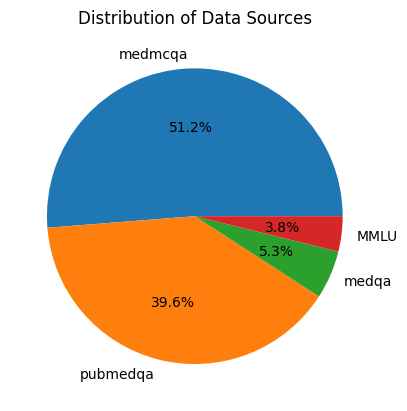

In [ ]:
plt.pie(df['dataset_name'].value_counts(), labels=df['dataset_name'].unique(), autopct='%1.1f%%')
plt.title('Distribution of Data Sources')
plt.show()

## Question & Answer Analysis

In [ ]:
print("\n=== Correct Answer Label Distribution by Question Type ===")
for q_type in df['question_type'].unique():
    print(f"\n--- {q_type} ---")
    subset_df = df[df['question_type'] == q_type]
    print(subset_df['answer_label'].value_counts(normalize=True))


=== Correct Answer Label Distribution by Question Type ===

--- MCQ ---
answer_label
A    0.276596
B    0.253856
C    0.249468
D    0.220080
Name: proportion, dtype: float64

--- Y/N ---
answer_label
yes    0.699336
no     0.300664
Name: proportion, dtype: float64


### Length Analysis

In [ ]:
df['question_char_len'] = df['question'].apply(len)
df['answer_char_len'] = df['answer'].apply(len)

df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

df['reasoning_char_len'] = df['reasoning'].apply(len)
df['reasoning_word_count'] = df['reasoning'].apply(lambda x: len(x.split()))

word_count_cols = ['question_word_count', 'answer_word_count', 'reasoning_word_count']

In [ ]:
print(df[word_count_cols].describe())

       question_word_count  answer_word_count  reasoning_word_count
count         15642.000000       15642.000000          15642.000000
mean             67.987406          33.623002            357.796254
std              61.777184          64.581107             67.588163
min               1.000000           1.000000            158.000000
25%              10.000000           2.000000            311.000000
50%              57.000000           5.000000            360.000000
75%             115.000000          43.000000            405.000000
max             705.000000        1263.000000            639.000000


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['question_token_count'] = df['question'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False, truncation=False)))
df['answer_token_count'] = df['answer'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False, truncation=False)))
df['reasoning_token_count'] = df['reasoning'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False, truncation=False)))

print(df[['question_token_count', 'answer_token_count', 'reasoning_token_count']].describe())

Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


       question_token_count  answer_token_count  reasoning_token_count
count          15642.000000        15642.000000           15642.000000
mean              98.011252           58.497762             612.908707
std               91.835642          116.141459             138.259359
min                2.000000            1.000000             220.000000
25%               14.000000            5.000000             512.000000
50%               79.000000           10.000000             617.000000
75%              162.000000           72.000000             710.000000
max              960.000000         4223.000000            1534.000000


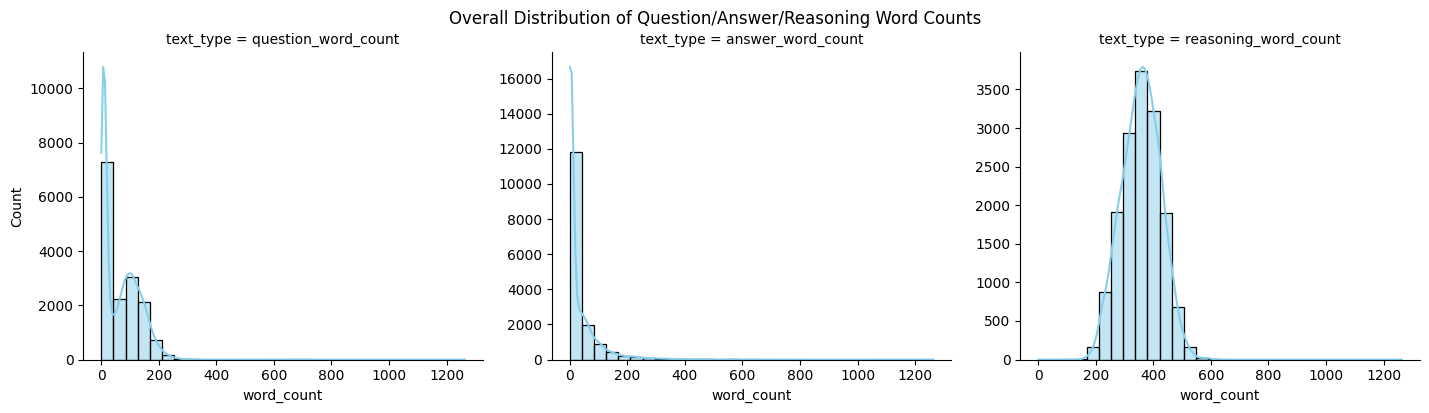

In [ ]:
# Melt the dataframe so we can facet by column
df_melt = df.melt(
    id_vars=['dataset_name'],
    value_vars=word_count_cols,
    var_name='text_type',
    value_name='word_count'
)

# Overall distribution: facet by text_type
sns.displot(
    df_melt,
    x='word_count',
    col='text_type',
    kind='hist',
    kde=True,
    bins=30,
    height=4,
    aspect=1.2,
    facet_kws={'sharey': False, 'sharex': False},
    color='skyblue'
)
plt.suptitle("Overall Distribution of Question/Answer/Reasoning Word Counts", y=1.02)
plt.show()

=== Overall Correlations ===
                      question_word_count  answer_word_count  \
question_word_count              1.000000          -0.400443   
answer_word_count               -0.400443           1.000000   
reasoning_word_count             0.217989          -0.010006   

                      reasoning_word_count  
question_word_count               0.217989  
answer_word_count                -0.010006  
reasoning_word_count              1.000000  


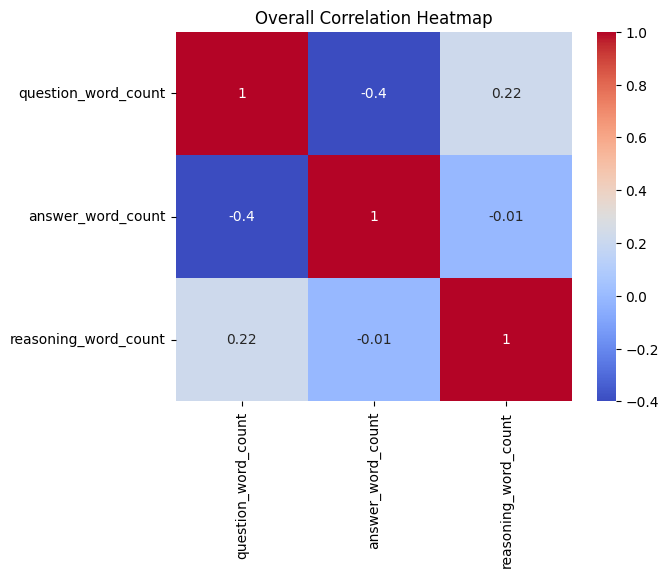

In [ ]:
print("=== Overall Correlations ===")
corr_overall = df[word_count_cols].corr()
print(corr_overall)

sns.heatmap(corr_overall, annot=True, cmap='coolwarm')
plt.title("Overall Correlation Heatmap")
plt.show()

Question ↔ Answer  
Moderate negative correlation  
Longer questions tend to have shorter answers overall. Suggests that dataset could contain very detailed questions but require concise answers.

### Vocab Analysis

In [ ]:
def vocab_size(df, text_col='question', dataset_col='dataset_name'):
    # Overall vocabulary
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[text_col].astype(str).fillna(''))
    overall_vocab = len(vectorizer.get_feature_names_out())
    print(f"Overall vocabulary size ({text_col}): {overall_vocab}")

    # Vocabulary per dataset
    print(f"\nVocabulary size per dataset source ({text_col}):")
    for dataset, subset in df.groupby(dataset_col):
        vectorizer_ds = CountVectorizer()
        X_ds = vectorizer_ds.fit_transform(subset[text_col].astype(str).fillna(''))
        vocab_ds = len(vectorizer_ds.get_feature_names_out())
        print(f"{dataset}: {vocab_ds}")

def get_vocab_set(text_series, stop_words='english'):
    vectorizer = CountVectorizer(stop_words=stop_words)
    vectorizer.fit(text_series.astype(str).fillna(''))
    return set(vectorizer.get_feature_names_out())

In [ ]:
vocab_size(df, text_col='question', dataset_col='dataset_name')

Overall vocabulary size (question): 21978

Vocabulary size per dataset source (question):
MMLU: 5096
medmcqa: 10117
medqa: 17571
pubmedqa: 2711


In [ ]:
vocab_size(df, text_col='answer', dataset_col='dataset_name')

Overall vocabulary size (answer): 38656

Vocabulary size per dataset source (answer):
MMLU: 1931
medmcqa: 36779
medqa: 6807
pubmedqa: 4728


In [ ]:
vocab_size(df, text_col='reasoning', dataset_col='dataset_name')

Overall vocabulary size (reasoning): 35041

Vocabulary size per dataset source (reasoning):
MMLU: 11190
medmcqa: 26439
medqa: 24099
pubmedqa: 9250


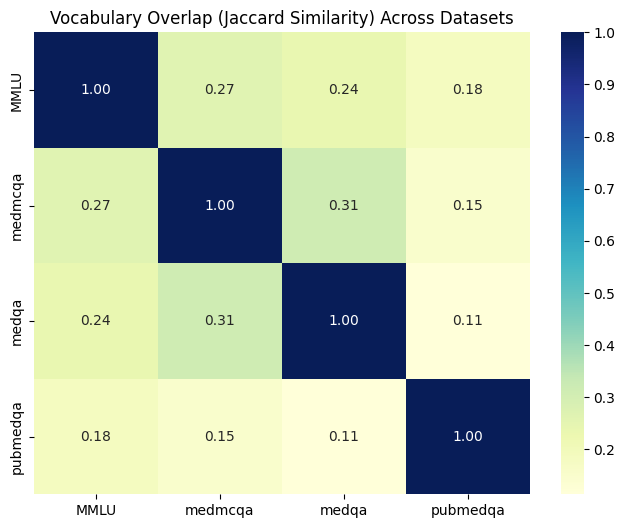

In [ ]:
dataset_vocab = {}
for dataset, subset in df.groupby('dataset_name'):
    dataset_vocab[dataset] = get_vocab_set(subset['question'])

datasets = list(dataset_vocab.keys())
overlap_matrix = pd.DataFrame(index=datasets, columns=datasets)

for ds1, ds2 in itertools.product(datasets, datasets):
    vocab1 = dataset_vocab[ds1]
    vocab2 = dataset_vocab[ds2]
    overlap_matrix.loc[ds1, ds2] = len(vocab1 & vocab2) / len(vocab1 | vocab2)

overlap_matrix = overlap_matrix.astype(float)
plt.figure(figsize=(8,6))
sns.heatmap(overlap_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Vocabulary Overlap (Jaccard Similarity) Across Datasets")
plt.show()


PubMedQA shares the least vocabulary with others ->  
Suggest more specialized or formal biomedical language

### Text Analysis

In [ ]:
def top_ngrams(df, text_col, top_n=20, ngram_size=1, stop_words='english', relative_freq=False):
    text_data = df[text_col].astype(str).fillna('')

    # Initialize vectorizer
    vectorizer = CountVectorizer(ngram_range=(ngram_size, ngram_size),
                                 stop_words=stop_words)
    X = vectorizer.fit_transform(text_data)

    # Sum up counts of each n-gram
    counts = X.sum(axis=0).A1
    ngrams = vectorizer.get_feature_names_out()

    # Create a sorted list of top n
    top_counts = sorted(zip(ngrams, counts), key=lambda x: x[1], reverse=True)[:top_n]

    # Convert to DataFrame
    top_df = pd.DataFrame(top_counts, columns=['ngram', 'count'])

    if relative_freq:
        # Relative frequency as % of dataset rows
        top_df['rel_freq'] = (top_df['count'] / len(df)) * 100

    return top_df

In [ ]:
top_words = top_ngrams(df, 'question', top_n=15, ngram_size=1)
print("=== Top 15 words ===")
print(top_words)

=== Top 15 words ===
          ngram  count
0       patient   9518
1     following   9283
2          year   8699
3           old   8385
4   examination   6213
5         shows   5722
6           min   5533
7         blood   5272
8       history   5186
9        likely   4604
10         pain   3974
11         past   3679
12     pressure   3658
13     physical   3550
14    physician   3272


In [ ]:
top_trigrams = top_ngrams(df, 'question', top_n=15, ngram_size=3)
print("=== Top 15 trigrams ===")
print(top_trigrams)

=== Top 15 trigrams ===
                              ngram  count
0                      year old man   2704
1                    year old woman   2283
2                min blood pressure   1380
3              past medical history   1215
4        physical examination shows    925
5                  old man presents    900
6      brought emergency department    870
7                     old man comes    749
8        following likely diagnosis    717
9                      year old boy    698
10               old woman presents    682
11                  old woman comes    677
12             min respiratory rate    652
13  examination shows abnormalities    595
14              man comes physician    583


In [ ]:
for dataset, subset in df.groupby('dataset_name'):
    print(f"\n=== Top 5 bigrams for dataset (col = question): {dataset} ===")
    top_trigrams = top_ngrams(subset, text_col='question', top_n=10, ngram_size=2, relative_freq=True)
    print(top_trigrams)

for dataset, subset in df.groupby('dataset_name'):
    print(f"\n=== Top 5 trigrams for dataset (col = question): {dataset} ===")
    top_trigrams = top_ngrams(subset, text_col='question', top_n=10, ngram_size=3, relative_freq=True)
    print(top_trigrams)


=== Top 5 bigrams for dataset (col = question): MMLU ===
                   ngram  count   rel_freq
0               year old    233  28.174123
1      examination shows    118  14.268440
2         blood pressure    102  12.333736
3                  mm hg    100  12.091898
4   physical examination     96  11.608222
5              min blood     75   9.068924
6              old woman     75   9.068924
7  following appropriate     73   8.827086
8                old man     68   8.222491
9       following likely     62   7.496977

=== Top 5 bigrams for dataset (col = question): medmcqa ===
                  ngram  count  rel_freq
0              year old    428  6.906568
1      likely diagnosis    114  1.839600
2              old male    103  1.662095
3               old man     93  1.500726
4          common cause     67  1.081168
5             old woman     65  1.048895
6    probable diagnosis     56  0.903663
7      following likely     55  0.887526
8            old female     55  0.88752

MMLU, MedMCQA, MedQA -> age-based patient scenarios common  (phrase "year old" dominates both bigrams and trigrams\)

PubMedQA is different, focuses on biomedical literature rather than clinical scenario QA.  
Low relative frequencies even for top ngrams -> questions are diverse, non-formulaic, and often disease-specific.